--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


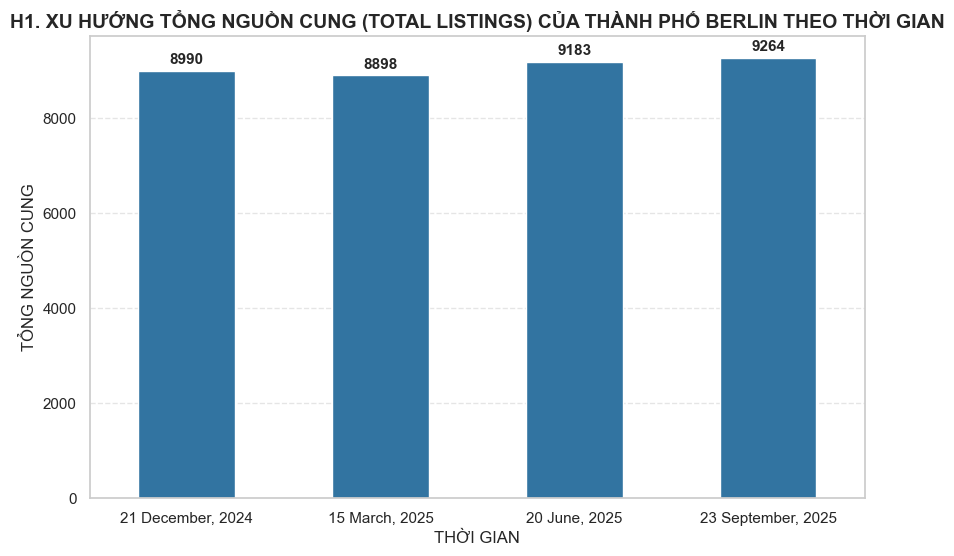

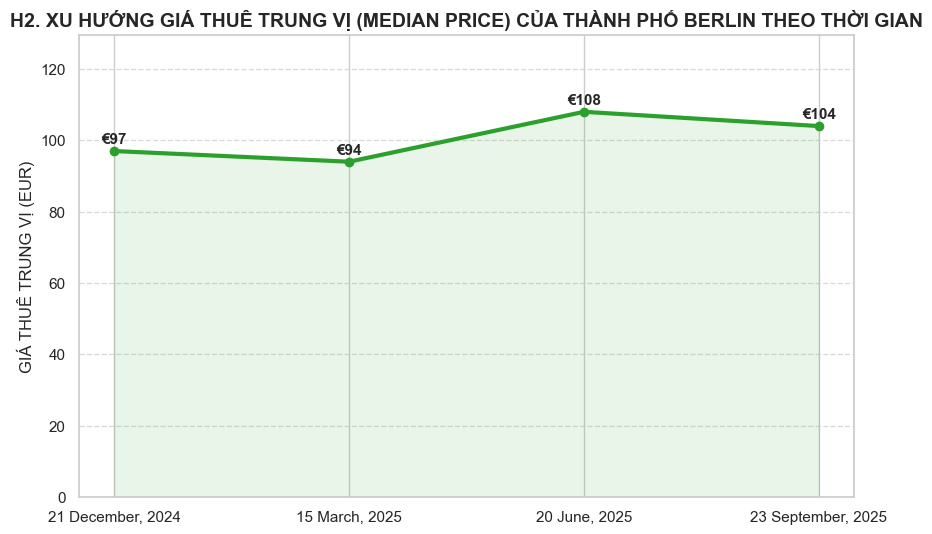

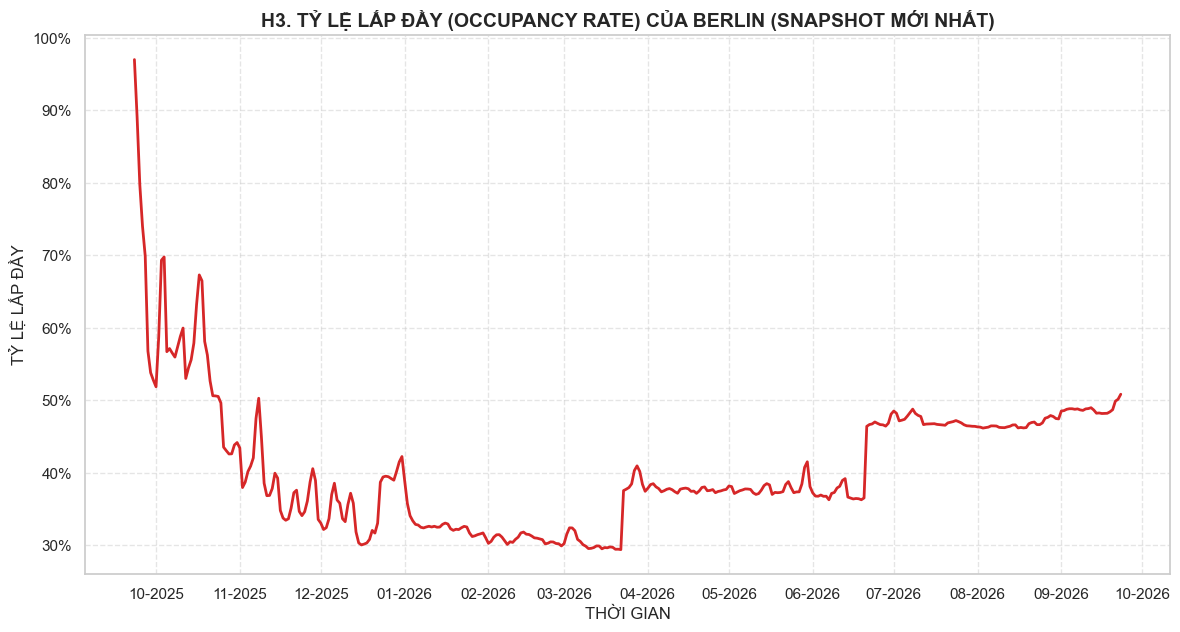

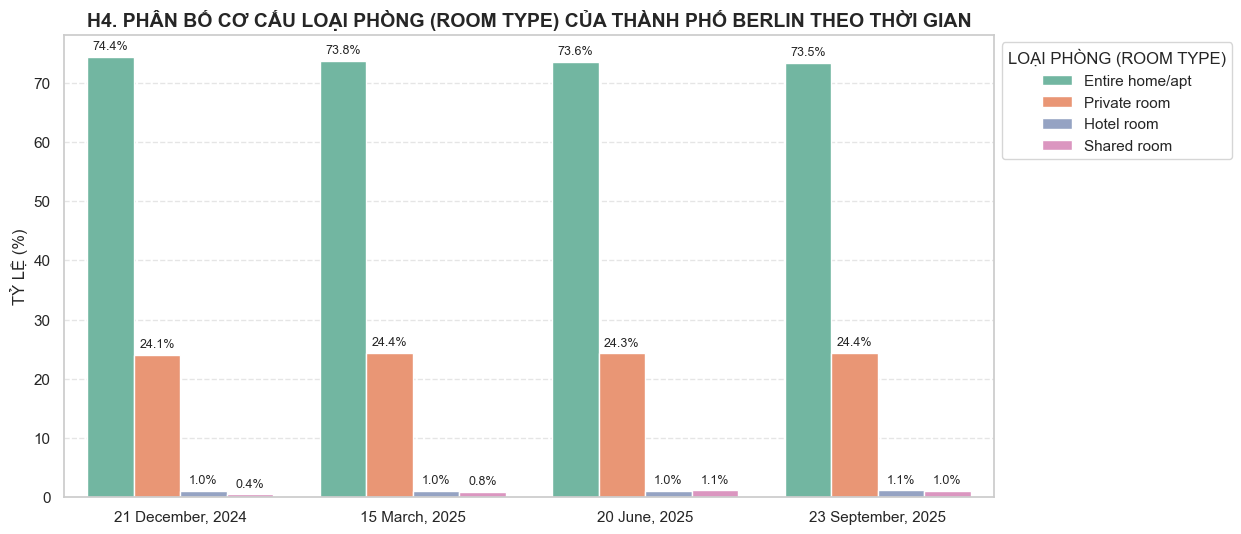

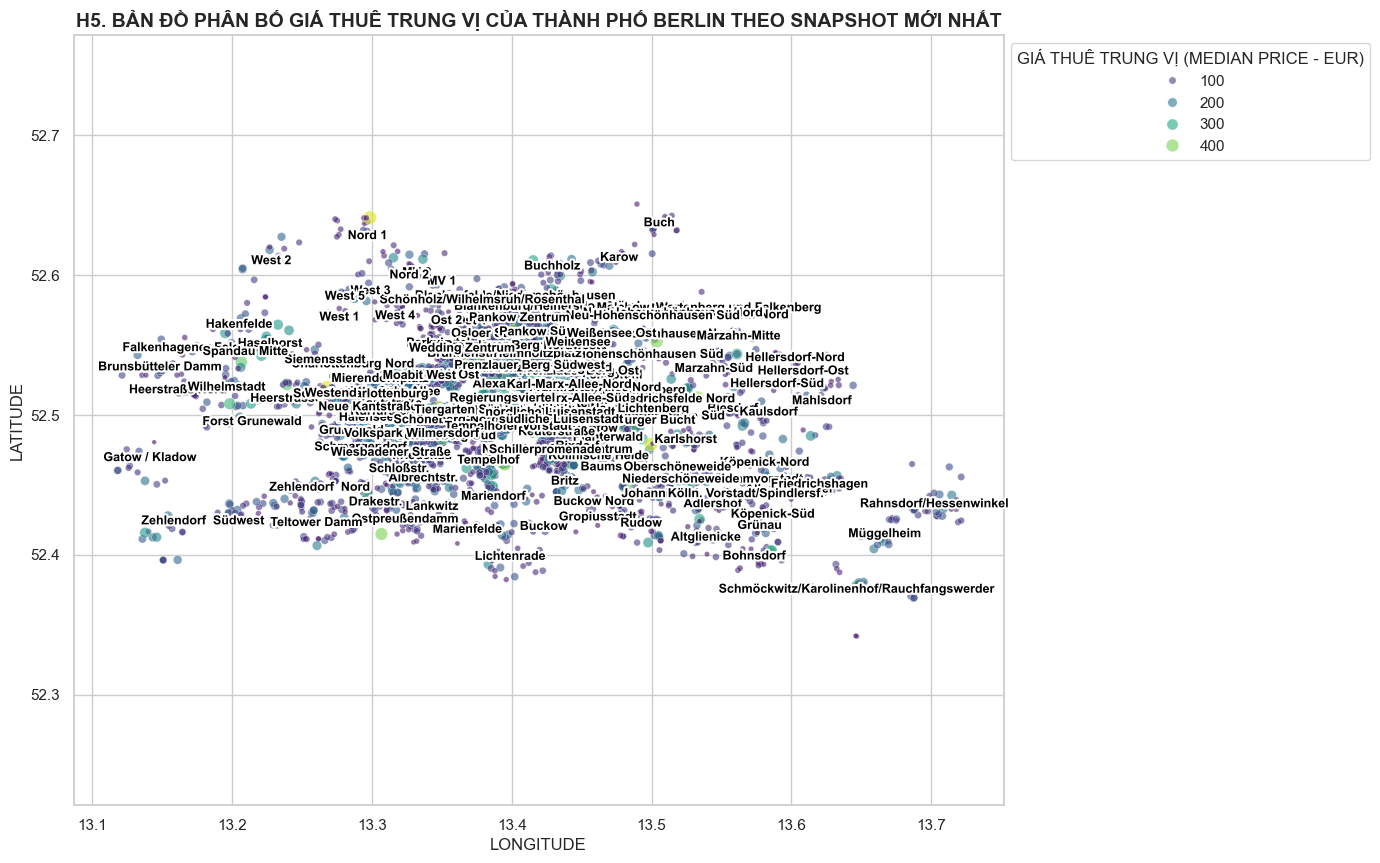

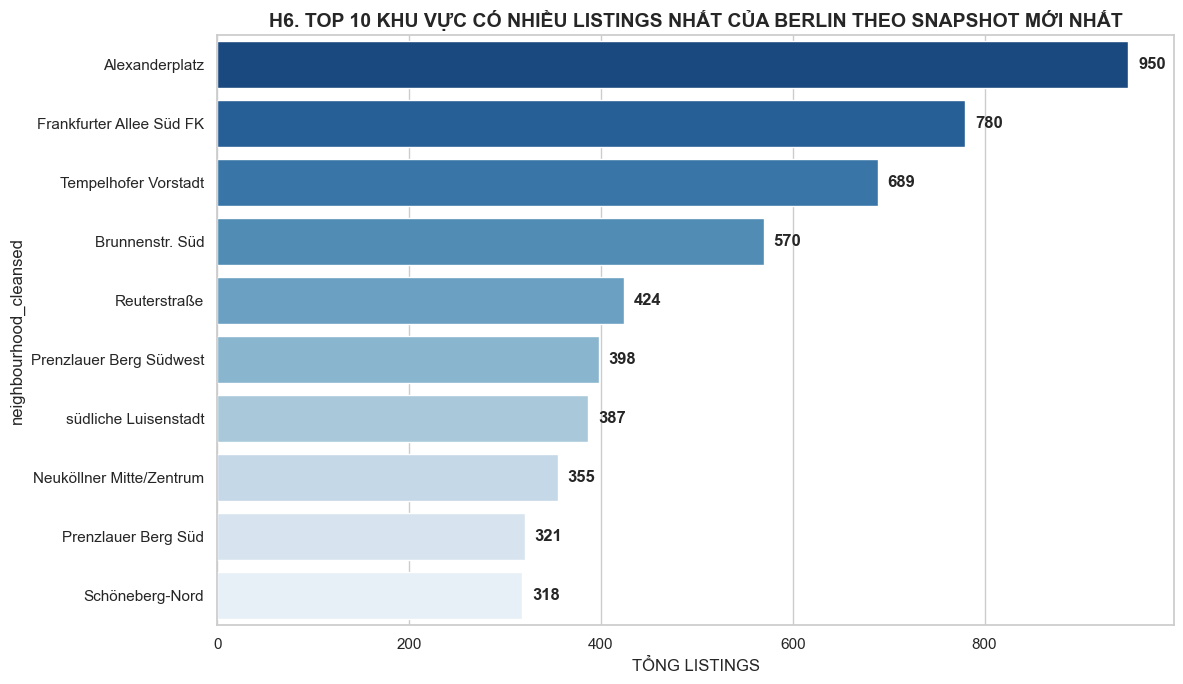

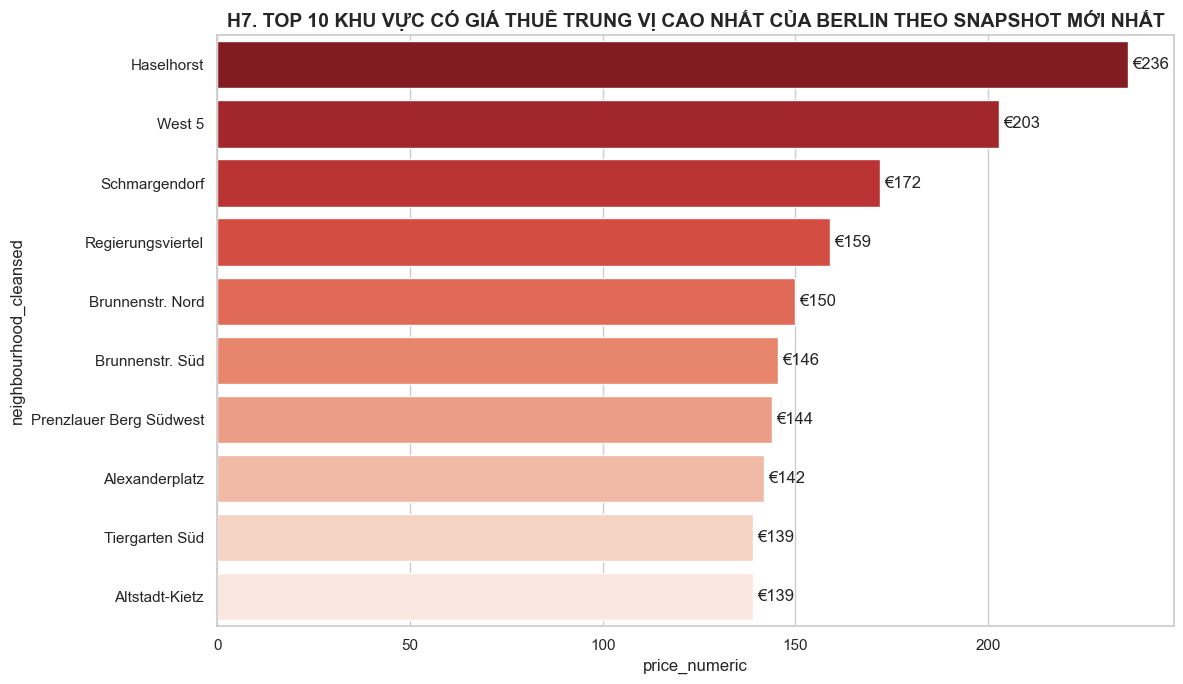

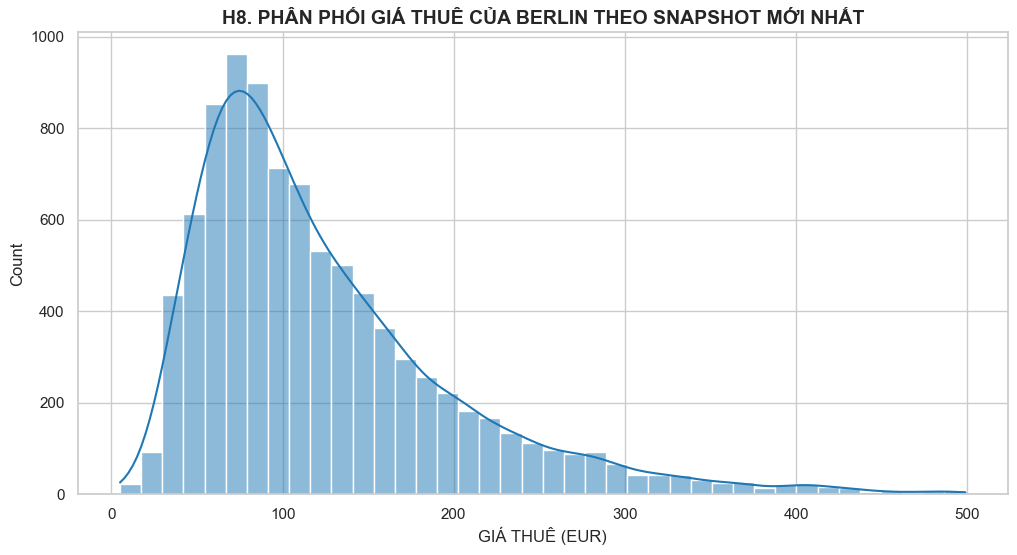

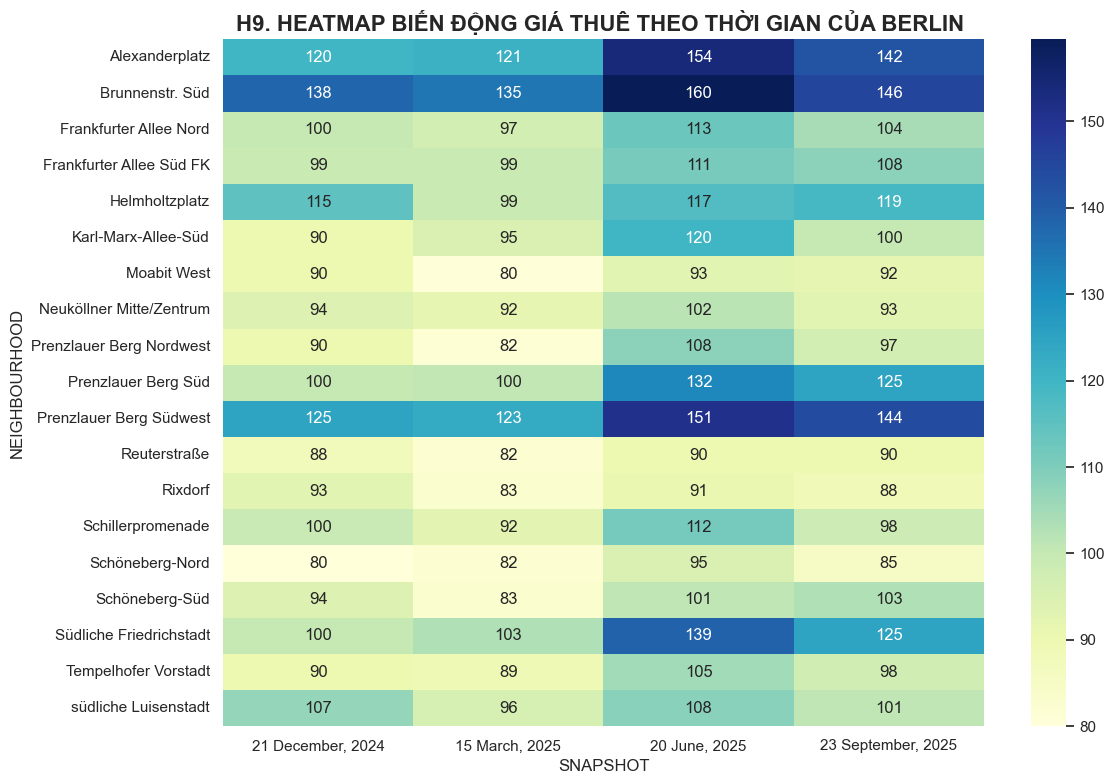

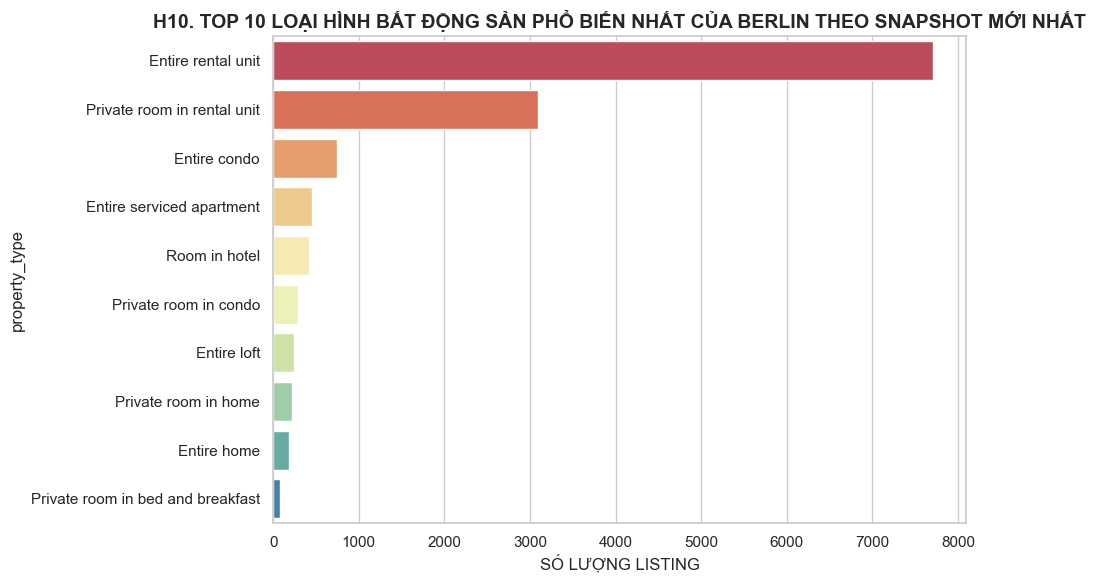

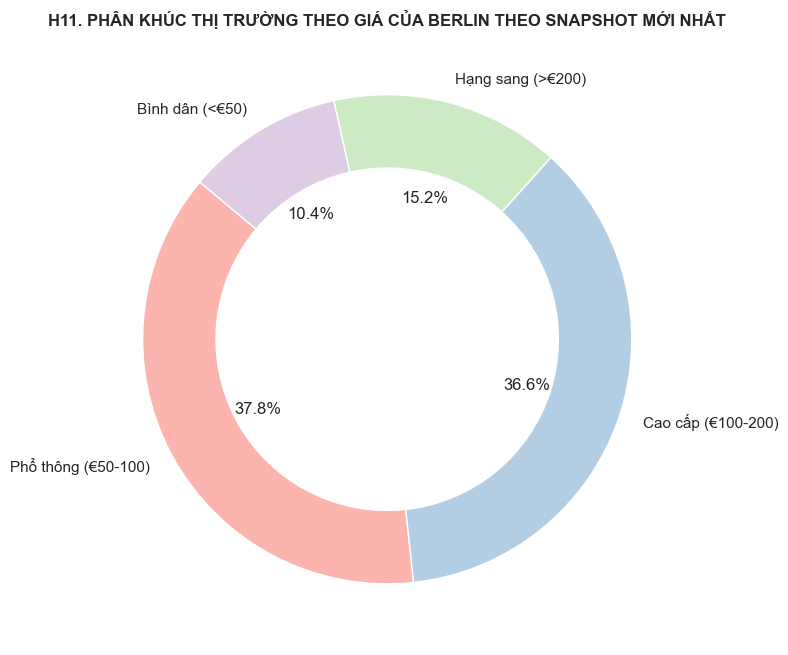

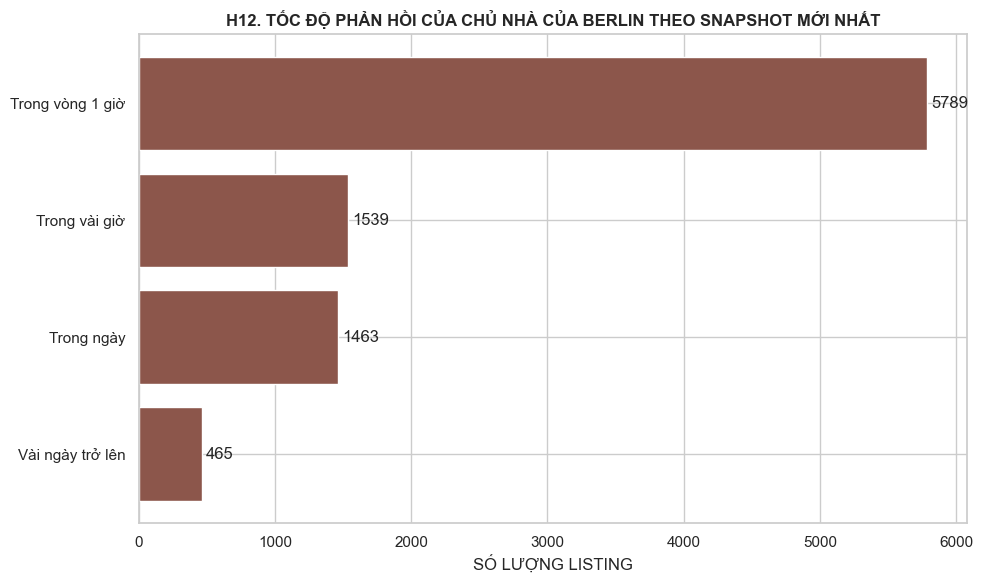

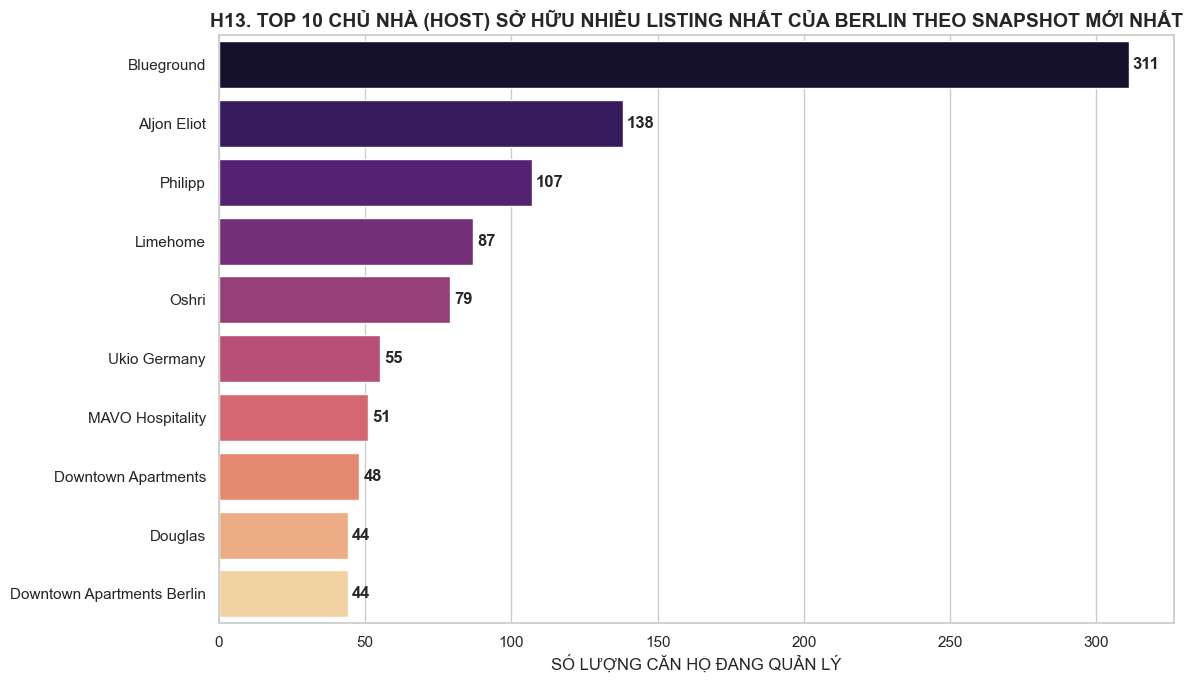

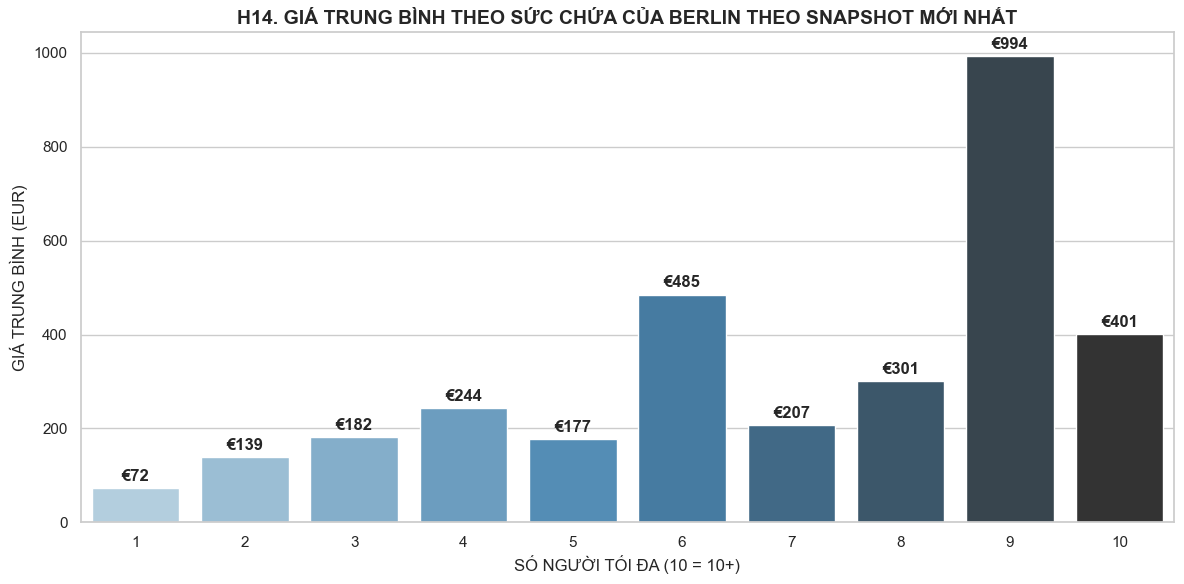

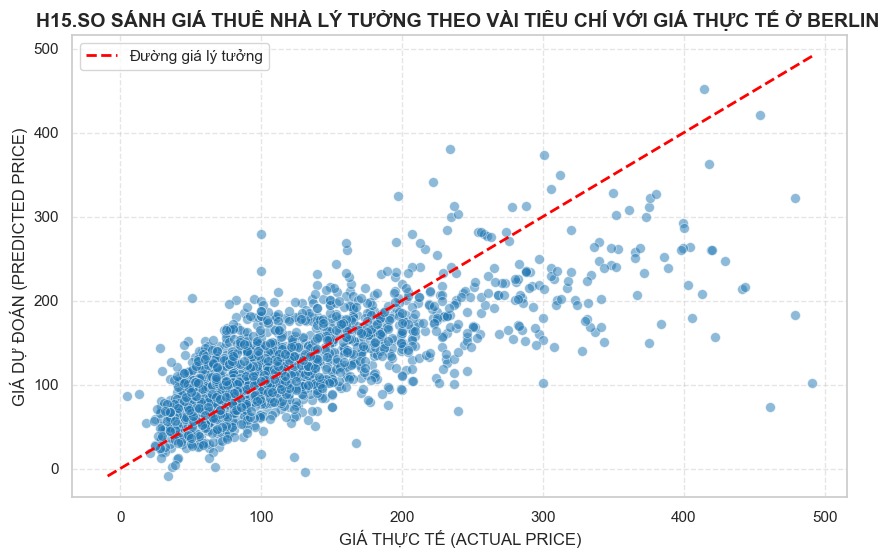

 ĐÃ HOÀN TẤT VẼ 15 BIỂU ĐỒ


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# --- 1. THIẾT LẬP ---
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'berlin')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'berlin'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BERLIN ---")

# --- 2. NẠP DỮ LIỆU KPI ---
try:
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))

    def sort_by_date(df, date_col='snapshot_date'):
        df['dt'] = pd.to_datetime(df[date_col], errors='coerce')
        return df.sort_values('dt')

    kpi_supply = sort_by_date(kpi_supply)

    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file KPI. Chi tiết: {e}")
    kpi_supply = pd.DataFrame()


# --- 3. NẠP DỮ LIỆU CHI TIẾT ---
from datetime import datetime

def parse_snapshot_name(name):
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]
    snapshots = sorted(snapshots, key=lambda x: parse_snapshot_name(x), reverse=True)

    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except: continue


# --- 4. VẼ BIỂU ĐỒ ---

# === H1: Xu hướng Nguồn Cung ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#1f77b4', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG')
    plt.xlabel('THỜI GIAN')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H2: Xu hướng Giá ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#2ca02c')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#2ca02c', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (EUR)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H3: Occupancy ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')

    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#d62728', linewidth=2)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        plt.title('H3. TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA BERLIN (SNAPSHOT MỚI NHẤT)', fontsize=14, fontweight='bold')
        plt.xlabel('THỜI GIAN')
        plt.ylabel('TỶ LỆ LẤP ĐẦY')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.savefig(os.path.join(FIGURES_DIR, 'berlin_03_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()

# === H4: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H4. PHÂN BỐ CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BERLIN THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_04_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    

# === H5: Bản đồ phân bố listing ===
if not df_detail.empty and 'latitude' in df_detail.columns:
    plt.figure(figsize=(12, 10))
    
    # Vẽ điểm (lọc giá < 500)
    sns.scatterplot(
        data=df_detail[df_detail['price_numeric'] < 500], 
        x='longitude', y='latitude', 
        hue='price_numeric', palette='viridis', 
        size='price_numeric', sizes=(10, 100), alpha=0.6,
        legend='brief'
    )

    # Gắn nhãn tên khu vực
    if 'neighbourhood_cleansed' in df_detail.columns:
        neigh_centers = df_detail.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean().reset_index()
        for i, row in neigh_centers.iterrows():
            txt = plt.text(
                row['longitude'], row['latitude'], 
                row['neighbourhood_cleansed'], 
                fontsize=9, fontweight='bold', color='black',
                ha='center', va='center'
            )
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

    plt.title(f'H5. BẢN ĐỒ PHÂN BỐ GIÁ THUÊ TRUNG VỊ CỦA THÀNH PHỐ BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('LONGITUDE')
    plt.ylabel('LATITUDE')
    plt.legend(title='GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)', bbox_to_anchor=(1, 1), loc='upper left')
    plt.axis('equal') 
    
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_05_map_labeled.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    
# === H6: Top 10 khu vực nhiều listing nhất ===
if not df_detail.empty:
    top_supply = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_supply, y='neighbourhood_cleansed', x='count', 
                hue='neighbourhood_cleansed', palette='Blues_r', legend=False)
    plt.title('H6. TOP 10 KHU VỰC CÓ NHIỀU LISTINGS NHẤT CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG LISTINGS')
    for i, v in enumerate(top_supply['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_06_top10_supply.pdf'))
    plt.show()
# === H7: Top 10 khu vực đắt nhất ===
if not df_detail.empty:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(data=neigh_price, y='neighbourhood_cleansed', x='price_numeric', 
                hue='neighbourhood_cleansed', palette='Reds_r', legend=False)
    plt.title('H7. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ CAO NHẤT CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_07_top10_price.pdf'))
    plt.show()
# === H8: Histogram giá ===
if not df_detail.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(df_detail[df_detail['price_numeric'] < 500]['price_numeric'], kde=True, bins=40, color='#1f77b4')
    plt.title('H8. PHÂN PHỐI GIÁ THUÊ CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_08_price_distribution.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H9: Heatmap giá theo thời gian ===
all_files = glob.glob(os.path.join(PROCESSED_DIR, '*', 'listings_processed.csv'))
if all_files:
    df_list = []
    for f in all_files:
        snap = os.path.basename(os.path.dirname(f))
        try:
            d = pd.read_csv(f, usecols=['neighbourhood_cleansed', 'price_numeric'], low_memory=False)
            d['snapshot'] = snap
            df_list.append(d)
        except: pass

    if df_list:
        df_heatmap = pd.concat(df_list)
        top_neighs = df_heatmap['neighbourhood_cleansed'].value_counts().head(19).index
        df_heatmap = df_heatmap[df_heatmap['neighbourhood_cleansed'].isin(top_neighs)]

        heatmap_data = df_heatmap.groupby(['neighbourhood_cleansed','snapshot'])['price_numeric'].median().unstack()
        sorted_cols = sorted(heatmap_data.columns, key=parse_snapshot_name)
        heatmap_data = heatmap_data[sorted_cols]

        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu')
        plt.title('H9. HEATMAP BIẾN ĐỘNG GIÁ THUÊ THEO THỜI GIAN CỦA BERLIN ', fontsize=16, fontweight='bold')
        plt.xlabel('SNAPSHOT'); plt.ylabel('NEIGHBOURHOOD')
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_DIR, 'berlin_09_heatmap.pdf'))
        plt.show()
# === H10: Top 10 Loại hình Bất động sản  ===
if not df_detail.empty and 'property_type' in df_detail.columns:
    top_props = df_detail['property_type'].value_counts().head(10)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_props.index, x=top_props.values, 
                hue=top_props.index, palette='Spectral', legend=False)
    plt.title('H10. TOP 10 LOẠI HÌNH BẤT ĐỘNG SẢN PHỔ BIẾN NHẤT CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('SỐ LƯỢNG LISTING')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_10_property_type.pdf'))
    plt.show()

# === H11: Phân khúc Giá (Donut Chart) ===
if not df_detail.empty:
    plt.figure(figsize=(8, 8))
    bins = [0, 50, 100, 200, 10000]
    labels = ['Bình dân (<€50)', 'Phổ thông (€50-100)', 'Cao cấp (€100-200)', 'Hạng sang (>€200)']
    df_detail['price_segment'] = pd.cut(df_detail['price_numeric'], bins=bins, labels=labels)
    seg_counts = df_detail['price_segment'].value_counts()
    
    plt.pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', startangle=140, 
            colors=sns.color_palette('Pastel1'), wedgeprops=dict(width=0.3))
    plt.title('H11. PHÂN KHÚC THỊ TRƯỜNG THEO GIÁ CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_11_price_segments.pdf'))
    plt.show()

# === H12: Tốc độ Phản hồi (Bar Chart) ===
if not df_detail.empty and 'host_response_time' in df_detail.columns:
    plt.figure(figsize=(10, 6))
    resp_data = df_detail['host_response_time'].value_counts(ascending=True)
    labels_map = {
        'within an hour': 'Trong vòng 1 giờ',
        'within a few hours': 'Trong vài giờ',
        'within a day': 'Trong ngày',
        'a few days or more': 'Vài ngày trở lên'
    }
    new_labels = [labels_map.get(l, l) for l in resp_data.index]
    
    bars = plt.barh(new_labels, resp_data.values, color='#8c564b')
    plt.title('H12. TỐC ĐỘ PHẢN HỒI CỦA CHỦ NHÀ CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontweight='bold')
    plt.xlabel('SỐ LƯỢNG LISTING')
    plt.bar_label(bars, padding=3)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_12_response_time.pdf'))
    plt.show()

# === H13: Top 10 Chủ nhà sở hữu nhiều phòng nhất ===
if not df_detail.empty and 'host_name' in df_detail.columns:
    top_hosts = df_detail.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).head(10).reset_index(name='count')
    
    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_hosts, y='host_name', x='count', 
                hue='host_name', palette='magma', legend=False)
    plt.title('H13. TOP 10 CHỦ NHÀ (HOST) SỞ HỮU NHIỀU LISTING NHẤT CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('SỐ LƯỢNG CĂN HỘ ĐANG QUẢN LÝ')
    plt.ylabel(None)
    
    ax = plt.gca()
    for i in ax.containers:
        ax.bar_label(i, padding=3, fontweight='bold')
        
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_13_top_hosts.pdf'))
    plt.show()

# === H14: Giá theo Sức chứa  ===
if not df_detail.empty and 'accommodates' in df_detail.columns:
    plt.figure(figsize=(12, 6))
    df_acc = df_detail.copy()
    df_acc['acc_group'] = df_acc['accommodates'].apply(lambda x: x if x < 10 else 10)
    avg_price_acc = df_acc.groupby('acc_group')['price_numeric'].mean().reset_index()

    sns.barplot(data=avg_price_acc, x='acc_group', y='price_numeric', 
                hue='acc_group', palette='Blues_d', legend=False)
    plt.title('H14. GIÁ TRUNG BÌNH THEO SỨC CHỨA CỦA BERLIN THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('SỐ NGƯỜI TỐI ĐA (10 = 10+)')
    plt.ylabel('GIÁ TRUNG BÌNH (EUR)')
    
    ax = plt.gca()
    for i in ax.containers:
        ax.bar_label(i, fmt='€%.0f', padding=3, fontweight='bold')
        
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, 'berlin_14_price_by_accomodation.pdf'))
    plt.show()

# === H15: DỰ ĐOÁN GIÁ BẰNG HỒI QUY TUYẾN TÍNH VÀ SO SÁNH GIÁ THỰC TẾ CỦA SNAPSHOT MỚI NHẤT ===
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import re

# Kiểm tra xem biến df_detail đã tồn tại chưa (từ các cell trước)
if 'df_detail' in globals() and not df_detail.empty:
    
    # ---  CHUẨN BỊ DỮ LIỆU (PREPROCESSING) ---
    
    # Tạo bản sao để không ảnh hưởng dữ liệu gốc
    df_reg = df_detail.copy()
    
    # A. Xử lý biến mục tiêu (Target): Lọc giá < 500 để loại bỏ nhiễu
    if 'price_numeric' in df_reg.columns:
        df_reg = df_reg[df_reg['price_numeric'] < 500]
        # Loại bỏ các dòng chưa có giá
        df_reg = df_reg.dropna(subset=['price_numeric'])
    
    # B. Xử lý các Features đặc biệt
    
    # 1. Host Superhost (t/f -> 1/0)
    if 'host_is_superhost' in df_reg.columns:
        df_reg['is_superhost'] = df_reg['host_is_superhost'].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)
    
    # 2. Amenities (Đếm số lượng tiện nghi)
    if 'amenities' in df_reg.columns:
        df_reg['amenities_count'] = df_reg['amenities'].astype(str).apply(lambda x: x.count(',') + 1)
        
    # 3. Bathrooms (Xử lý bathrooms_text nếu bathrooms rỗng)
    if 'bathrooms_text' in df_reg.columns:
        def extract_bath_num(text):
            try:
                # Tìm số đầu tiên trong chuỗi (vd: "1.5 baths" -> 1.5)
                return float(re.findall(r"[-+]?\d*\.\d+|\d+", str(text))[0])
            except:
                return 1.0 # Giá trị mặc định nếu lỗi
        df_reg['bathrooms_calc'] = df_reg['bathrooms_text'].apply(extract_bath_num)
    elif 'bathrooms' in df_reg.columns:
        df_reg['bathrooms_calc'] = df_reg['bathrooms']
    else:
        df_reg['bathrooms_calc'] = 1.0 # Mặc định
        
    # 4. Điền dữ liệu thiếu cho các cột số (Bedrooms, Beds, Rating)
    for col in ['bedrooms', 'beds', 'accommodates', 'review_scores_rating']:
        if col in df_reg.columns:
            df_reg[col] = df_reg[col].fillna(df_reg[col].median())

    # ---  CHỌN FEATURES CHO MÔ HÌNH ---
    # Danh sách các cột tiềm năng
    potential_numeric = ['accommodates', 'bedrooms', 'beds', 'bathrooms_calc', 'amenities_count', 'review_scores_rating', 'is_superhost']
    potential_categorical = ['property_type', 'room_type', 'neighbourhood_cleansed']
    
    # Lọc những cột thực sự có trong data
    numeric_feats = [c for c in potential_numeric if c in df_reg.columns]
    categorical_feats = [c for c in potential_categorical if c in df_reg.columns]
    
    # Tạo dataset cho mô hình
    X_raw = df_reg[numeric_feats + categorical_feats]
    y = df_reg['price_numeric']
    
    # One-Hot Encoding cho biến phân loại (Property, Room, Neighborhood)
    # drop_first=True để tránh đa cộng tuyến
    X = pd.get_dummies(X_raw, columns=categorical_feats, drop_first=True)
    
    # Xử lý các giá trị NaN nếu còn tồn tại
    X = X.fillna(0)
    
    # --- 4. HUẤN LUYỆN MÔ HÌNH (TRAINING) ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    # --- 5. ĐÁNH GIÁ & VẼ BIỂU ĐỒ ---
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    plt.figure(figsize=(10, 6))
    
    # Vẽ Scatter Plot
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='#1f77b4', edgecolor='w', s=50)
    
    # Vẽ đường giá nhà lý tưởng 
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', linewidth=2, label='Đường giá lý tưởng')
    
    plt.title(f'H15.SO SÁNH GIÁ THUÊ NHÀ LÝ TƯỞNG THEO VÀI TIÊU CHÍ VỚI GIÁ THỰC TẾ Ở BERLIN ', 
              fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THỰC TẾ (ACTUAL PRICE)')
    plt.ylabel('GIÁ DỰ ĐOÁN (PREDICTED PRICE)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Lưu và hiển thị
    save_path = os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_15_simple_price_linear_regression.pdf')
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    


else:
    print(" CẢNH BÁO: Không tìm thấy 'df_detail'.")
print(" ĐÃ HOÀN TẤT VẼ 15 BIỂU ĐỒ")